# PRÁCTICA 2: Clasificación de tweets

El objetivo de esta práctica es extraer contenido de Twitter, procesar los tweets extraídos y realizar experimentos básicos de clasificación.

Primeramente, haciendo uso de la librería [tweepy](http://docs.tweepy.org/en/latest/), se extraerán tweets de **2 pares** de personas:

- **Un par de personas no-relacionadas**: en este caso se van a considerar los tweets de Neil deGrasse Tyson (divulgador de temas relacionados a la astrofísica) y los de Britney Spears (cantante). 
    
- **Un par de personas relacionadas**: en este caso se van a considerar los tweets de Russell Westbrook y James Harden (ambos jugadores de basket que compartieron equipo cuando estuvieron en los Oklahoma City Thunder y en los Houston Rockets).

Luego, para cada par, se entrenará un clasificador con el 70% de los tweets más antiguos y se testeará con el 30% de los tweets más recientes. Las variables explicativas serán las frecuencias de los términos en los tweets y la variable a predecir será el autor de cada tweet. Para esto se utilizará la librería scikit-learn de Python. Ver [sklearn.feature_extraction_text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) y [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

Por último, se analizarán los resultados obtenidos utilizando distintos parámetros (kernel y C) a través de la comparación de la accuracy y de las matrices de confusión.

La **hipótesis** es que los tweets del par de personas que están relacionadas son más difíciles de discriminar que los tweets del par de personas que no están relacionadas.

## Extracción y preprocesamiento de tweets

**Se importan las librerías necesarias**

In [163]:
import tweepy
import json
import pandas as pd
import datetime
from sklearn import feature_extraction
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
import datetime as dt

**Se configuran los datos necesarios para acceder a la API de Twitter**

In [158]:
consumer_key='fjbmjHZ14HbUDHkzxCsDAkijL'
consumer_secret='DNpUkf0fD2FRtYZ6lNB8d14dv9a1usPGFh2orSvT6PQ6DEZSNQ'
access_token_key='1059276888529612800-tedlSyM9ttlTZrtbZ5gUbUZ3J6RlJp'
access_token_secret='jagh9qgG3BwpgWS8pNFuz1wkTpXVsRKZ1bKShfWn0nUue'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True) 

**Se extraen los tweets**

In [159]:
users = ['@russwest44', '@britneyspears', '@neiltyson', '@JHarden13']


for user in users:
    results=[] 

    timeline = tweepy.Cursor(api.user_timeline, screen_name= user, include_rts=False, exclude_replies=True, tweet_mode="extended").items()
    for status in timeline:
        data = (
        status.id,
        status.user.id,
        status.user.screen_name,
        status.user.name,
        status.full_text,
        status.created_at,
        status.lang)
        results.append(data)    

    cols = "id user_id screen_name name text date lang".split()
    df = pd.DataFrame(results, columns=cols)    
    df.to_csv (f'tweets_{user[1:]}.csv', index = False) 
    
    results=[]

**Se leen los tweets**

In [165]:
britneyspears=pd.read_csv('tweets_britneyspears.csv', parse_dates=['date'])
neiltyson=pd.read_csv('tweets_neiltyson.csv', parse_dates=['date'])
RussWest=pd.read_csv('tweets_russwest44.csv', parse_dates=['date'])
JamesHarden=pd.read_csv('tweets_JHarden13.csv', parse_dates=['date'])

**Separación en train y test**

Para cada usuario, el conjunto de entrenamiento corresponde al 70% de los tweets más antiguos, y el conjunto de test corresponde al 30% de los tweets más recientes. 

In [166]:
#Britney Spears
britneyspears_test = britneyspears.head(int(0.3 * len(britneyspears)))
britneyspears_train = britneyspears.tail(int(0.7 * len(britneyspears)))

#Neil deGrasse Tyson
neiltyson_test = neiltyson.head(int(0.3 * len(neiltyson)))
neiltyson_train = neiltyson.tail(int(0.7 * len(neiltyson)))

#Russell Westbrook
RussWest_test = RussWest.head(int(0.3 * len(RussWest)))
RussWest_train = RussWest.tail(int(0.7 * len(RussWest)))

#James Harden
JamesHarden_test = JamesHarden.head(int(0.3 * len(JamesHarden)))
JamesHarden_train = JamesHarden.tail(int(0.7 * len(JamesHarden)))

## Corpus de personas no-relacionadas

### @neiltyson vs. @britneyspears

Cantidad de tweets considerados de Britney Spears.

In [184]:
print (len(britneyspears))

1921


Cantidad de tweets considerados de Neil deGrasse Tyson.

In [185]:
print (len(neiltyson))

2183


Se observa que la cantidad de tweets de ambos usuarios es similar.

**Bag of Words - Train**

Se agregan los tweets tanto de Britney Spears como de Neil deGrasse Tyson al corpus de entrenamiento. Se incluye el 70% de los tweets más antiguos y se consideran solamente los tweets. Se excluyen las respuestas y los retweets.

In [147]:
corpus_train_primer_par = []

for row_index,row in britneyspears_train.iterrows():
    corpus_train_primer_par.append(row['text'])
    
for row_index,row in neiltyson_train.iterrows():
    corpus_train_primer_par.append(row['text'])

Se vectoriza el corpus y se obtiene una matriz cuyas filas representan a los tweets y cuyas columnas representan a los términos. El valor de cada celda es la frecuencia de cada término (tf) en cada tweet (documento).
Para obtener la matriz se reemplazan las mayúsculas por minúsculas, se descartan las stop_words y se consideran los términos que aparecen por lo menos en 3 tweets.

In [182]:
vectorizer_primer_par_train = feature_extraction.text.CountVectorizer(lowercase=True, stop_words='english', min_df=3)
vectorizer_p_train = vectorizer_primer_par_train.fit_transform(corpus_train_primer_par)
df_tf_primer_par_train = pd.DataFrame(vectorizer_p_train.todense(), columns=vectorizer_primer_par_train.get_feature_names())
df_tf_primer_par_train.shape

(2872, 1883)

El corpus obtenido contiene 2872 tweets y se consideran 1883 términos.

**Creación del vector con la variable a predecir: entrenamiento**

Los tweets representados por un **1** corresponden a Britney Spears y los representados por un **0** corresponden a Neil deGrasse Tyson. 

In [183]:
vector_tweets_primer_par_train = [1] * len(britneyspears_train) + [0] * len(neiltyson_train)
print (len(vector_tweets_primer_par_train))

2872


Se compueba que la longitud del vector es la misma que la de la matriz.

**Breve análisis del vocabulario utilizado por los usuarios**

Britney Spears

- Cantidad de términos utilizados

In [239]:
corpus_britneyspears=df_tf_primer_par_train[0:len(britneyspears_train)]
corpus_britneyspears=corpus_britneyspears.sum()
corpus_britneyspears=pd.DataFrame(corpus_britneyspears)
corpus_britneyspears.columns=['sum_frequency']
len(corpus_britneyspears.loc[corpus_britneyspears.sum_frequency > 0])

1124

Se observa que utilizó en sus tweets de entrenamiento 1124 de los 1883 términos del corpus, es decir, un **59.7%** del total.

- Términos más frecuentes

In [240]:
corpus_britneyspears.sort_values(by=['sum_frequency'], ascending=False)[:50]

,sum_frequency
http,489
https,485
amp,144
pieceofme,132
love,114
thank,112
vegas,101
tonight,98
new,96
today,78


Se observa que algunos términos utilizados por la misma (como **pieceofme**, **iambritneyjean**, **britneyjeanlisteningparty**) son hashtags propios de su persona lo que podría aportar significativamente a la clasificación correcta de sus tweets.

Otros términos, como **song** y **shows** también se pueden reconocer como característicos de este usuario dado que hacen referencia a la música. 

Neil deGrasse Tyson

- Cantidad de términos utilizados

In [241]:
corpus_neiltyson=df_tf_primer_par_train[len(britneyspears_train):]
corpus_neiltyson=corpus_neiltyson.sum()
corpus_neiltyson=pd.DataFrame(corpus_neiltyson)
corpus_neiltyson.columns=['sum_frequency']
len(corpus_neiltyson.loc[corpus_neiltyson.sum_frequency > 0])

1585

Se observa que utilizó en sus tweets de entrenamiento 1585 de los 1883 términos del corpus, es decir, un **84.2%** del total.

- Términos más frecuentes

In [242]:
corpus_neiltyson.sort_values(by=['sum_frequency'], ascending=False)[:50]

,sum_frequency
amp,375
https,352
just,179
earth,144
http,144
startalkradio,126
posted,123
moon,92
day,83
science,83


Se observa que algunos términos utilizados por el mismo (como **startalkradio**, **itunepodcasts**) son hashtags que utiliza con frecuencia. Startalkradio es un podcast que Neil deGrasse Tyson transmite a través de iTunes. 

Otros términos, como **earth**, **moon**, **universe**, **sun**, **cosmic**, **space**, **planet** y **science** también se pueden reconocer como característicos de este usuario dado que hacen referencia a la astrofísica.

**Vectorización del corpus de test**

Se procede de manera similar que en el caso del corpus de entrenamiento. La diferencia es que luego de obtener la matriz de test, se seleccionan solamente los términos que aparecen en la matriz de entrenamiento, de manera tal que las dos matrices contengan las mismas columnas. Como puede haber términos que aparezcan en el corpus de entrenamiento y no en el de test, es probable que la matriz de test quede con columnas vacías. 

In [150]:
corpus_test_primer_par = []

for row_index,row in britneyspears_test.iterrows():
    corpus_test_primer_par.append(row['text'])
    
for row_index,row in neiltyson_test.iterrows():
    corpus_test_primer_par.append(row['text'])

In [243]:
vectorizer_primer_par_test = feature_extraction.text.CountVectorizer(lowercase=True, stop_words='english')
vectorizer_p_test = vectorizer_primer_par_test.fit_transform(corpus_test_primer_par)
df_tf_primer_par_test = pd.DataFrame(vectorizer_p_test.todense(), columns=vectorizer_primer_par_test.get_feature_names())

(1230, 5682)

Se seleccionan únicamente las columnas que aparecen en la matriz de entrenamiento.

In [245]:
df_primer_par_test = pd.DataFrame()

columns_to_select_primer_par = []

for word in vectorizer_primer_par_test.get_feature_names():
    if word in vectorizer_primer_par_train.get_feature_names():
        columns_to_select_primer_par.append(word)
        
#Se crea una matriz vacía cuyas columnas son las que figuran en la matriz de entrenamiento
for item in vectorizer_primer_par_train.get_feature_names():
    df_primer_par_test[item] = [0] * len (vector_tweets_primer_par_test)
    
#Se reemplazan las columnas coincidentes
for column in columns_to_select_primer_par:
    df_primer_par_test[column] = df_tf_primer_par_test[column]
    
df_primer_par_test.shape

(1230, 1883)

Se observa que la cantidad de columnas en la matriz de test resultante es igual a la de entrenamiento.

**Creación del vector con la variable a predecir: test**

Los tweets representados por un **1** corresponden a Britney Spears y los representados por un **0** corresponden a Neil deGrasse Tyson. 

In [246]:
vector_tweets_primer_par_test = [1] * len(britneyspears_test) + [0] * len(neiltyson_test)
print (len(vector_tweets_primer_par_test))

1230


Se observa que la longitud del vector es la misma que la de la matriz.

### Entrenamiento del clasificador

Se utilizarán Máquinas de vectores de soporte (SVM por sus siglas en inglés).

Se probarán diferentes *kernels* y diferentes parámetros *C*.

In [ ]:
C = range(1, 80, 2)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

scores_primer_par=[]

for c in C:
    for k in kernels:
        clf_primer_par = svm.SVC(kernel=k, C=c)
        clf_primer_par.fit(df_tf_primer_par_train, vector_tweets_primer_par_train)
        clf_primer_par.predict(df_primer_par_test)
        scores_primer_par.append([c, clf_primer_par.score(df_primer_par_test, vector_tweets_primer_par_test), k])
        
scores_c_primer_par=[i[0] for i in scores_primer_par]
scores_y_primer_par=[i[1] for i in scores_primer_par]
scores_k_primer_par=[i[2] for i in scores_primer_par]

df_primer_par=pd.DataFrame()
df_primer_par['c']=scores_c_primer_par
df_primer_par['accuracy']=scores_y_primer_par
df_primer_par['k']=scores_k_primer_par

cmap = {'linear': 'red', 'poly': 'blue', 'rbf': 'green', 'sigmoid': 'yellow'}

**Gráfico con los resultados de test**

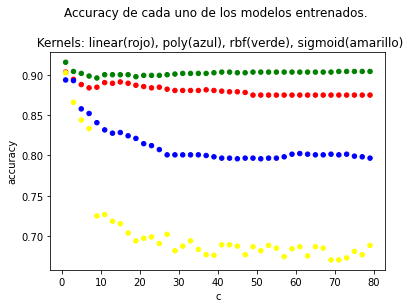

In [254]:
df_primer_par.plot('c', 'accuracy', kind='scatter',  
    c=[cmap.get(c, 'black') for c in df_primer_par.k])
plt.title("Accuracy de cada uno de los modelos entrenados. \n \n Kernels: linear(rojo), poly(azul), rbf(verde), sigmoid(amarillo)")
plt.show()

En términos generales, se puede decir que el kernel *rbf* resultó en mejores accuracy en el rango del parámetro C explorado.

El segundo en performance es el *linear*.

Por otro lado, las mayores accuracy se consiguen con *menores* valores del parámetro C.

Exceptuando a los modelos que se entrenaron utilizando el kernel *sigmoid*, todos los modelos tienen un accuracy mayor al 79%.

In [263]:
pd.DataFrame(df_primer_par.groupby('k').describe()['accuracy'][['min','max', 'mean', '50%']])

,min,max,mean,50%
k,,,,
linear,0.874797,0.903252,0.880813,0.880081
poly,0.795935,0.893496,0.812073,0.800813
rbf,0.895935,0.915447,0.902195,0.902846
sigmoid,0.670732,0.902439,0.706626,0.687805


La máxima accuracy alcanzada es similar para todos los kernels probados (**89.3-91.5%**)

**Matriz de confusión**

Mejores parámetros para cada kernel.

In [285]:
df_linear=pd.DataFrame(df_primer_par.loc[df_primer_par['k']=='linear'].sort_values(['accuracy'], ascending=False).iloc[0])
df_linear

,0
c,1
accuracy,0.903252
k,linear


In [286]:
df_poly=pd.DataFrame(df_primer_par.loc[df_primer_par['k']=='poly'].sort_values(['accuracy'], ascending=False).iloc[0])
df_poly

,1
c,1
accuracy,0.893496
k,poly


In [287]:
df_rbf=pd.DataFrame(df_primer_par.loc[df_primer_par['k']=='rbf'].sort_values(['accuracy'], ascending=False).iloc[0])
df_rbf

,2
c,1
accuracy,0.915447
k,rbf


In [288]:
df_sigmoid=pd.DataFrame(df_primer_par.loc[df_primer_par['k']=='sigmoid'].sort_values(['accuracy'], ascending=False).iloc[0])
df_sigmoid

,3
c,1
accuracy,0.902439
k,sigmoid


Se muestran las matrices de confusión correspondientes al modelo con mayor accuracy de cada kernel.

*Linear*

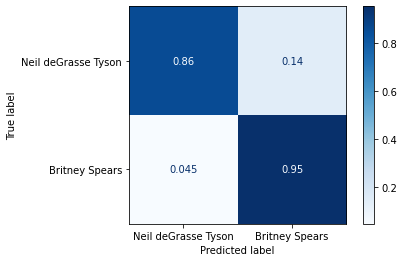

In [298]:
clf_primer_par = svm.SVC(kernel='linear', C=1)
clf_primer_par.fit(df_tf_primer_par_train, vector_tweets_primer_par_train)
clf_primer_par.predict(df_primer_par_test)

plot_confusion_matrix(clf_primer_par, df_primer_par_test, vector_tweets_primer_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Neil deGrasse Tyson', 'Britney Spears'])
plt.show()

*Poly*

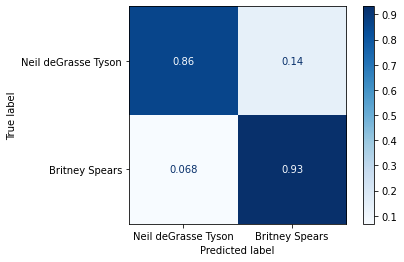

In [299]:
clf_primer_par = svm.SVC(kernel='poly', C=1)
clf_primer_par.fit(df_tf_primer_par_train, vector_tweets_primer_par_train)
clf_primer_par.predict(df_primer_par_test)

plot_confusion_matrix(clf_primer_par, df_primer_par_test, vector_tweets_primer_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Neil deGrasse Tyson', 'Britney Spears'])
plt.show()

*Rbf*

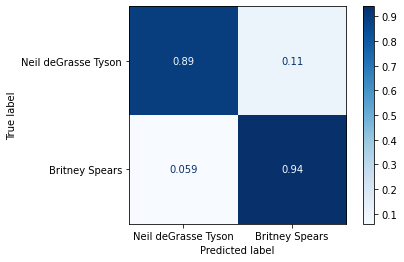

In [311]:
clf_primer_par = svm.SVC(kernel='rbf', C=1)
clf_primer_par.fit(df_tf_primer_par_train, vector_tweets_primer_par_train)
clf_primer_par.predict(df_primer_par_test)

plot_confusion_matrix(clf_primer_par, df_primer_par_test, vector_tweets_primer_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Neil deGrasse Tyson', 'Britney Spears'])
plt.show()

*Sigmoid*

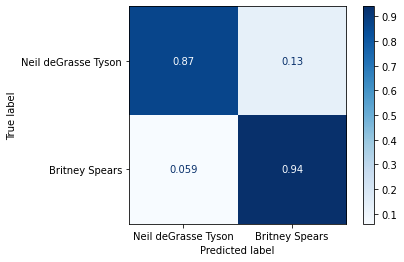

In [300]:
clf_primer_par = svm.SVC(kernel='sigmoid', C=1)
clf_primer_par.fit(df_tf_primer_par_train, vector_tweets_primer_par_train)
clf_primer_par.predict(df_primer_par_test)

plot_confusion_matrix(clf_primer_par, df_primer_par_test, vector_tweets_primer_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Neil deGrasse Tyson', 'Britney Spears'])
plt.show()

**Observaciones**

Como se mencionó anteriormente, la **accuracy** de los mejores modelos se encuentra entre el **89.3** y el **91.5%**, valores que pueden considerarse altos.

En las cuatro matrices de confusión presentadas se observan resultados similares. Los tweets de **Britney Spears** son correctamente clasificados en alrededor del **93-95%** de los casos, mientras que los tweets de **Neil deGrasse Tyson** son clasificados correctamente en el **86-89%** de los casos.  

Cabe destacar el uso de diferentes **hashtags** por parte de los dos usuarios.

## Corpus de personas no-relacionadas:

### @russwest44 vs. @JHarden13

Cantidad de tweets considerados de Russell Westbrook.

In [302]:
print (len(RussWest))

2585


Cantidad de tweets considerados de James Harden.

In [304]:
print (len(JamesHarden))

2309


Se observa que la cantidad de tweets de ambos usuarios es similar.

**Bag of Words - Train**

Se agregan los tweets tanto de Russell Westbrook como de James Harden al corpus de entrenamiento. Se incluye el 70% de los tweets más antiguos y se consideran solamente los tweets. Se excluyen las respuestas y los retweets.

In [167]:
corpus_train_segundo_par = []

for row_index,row in  RussWest_train.iterrows():
    corpus_train_segundo_par.append(row['text'])
    
for row_index,row in  JamesHarden_train.iterrows():
    corpus_train_segundo_par.append(row['text'])

Se vectoriza el corpus y se obtiene una matriz cuyas filas representan a los tweets y cuyas columnas representan a los términos. El valor de cada celda es la frecuencia de cada término (tf) en cada tweet (documento). Para obtener la matriz se reemplazan las mayúsculas por minúsculas, se descartan las stop_words y se consideran los términos que aparecen por lo menos en 3 tweets.

In [305]:
vectorizer_segundo_par_train = feature_extraction.text.CountVectorizer(lowercase=True, stop_words='english', min_df=3)
vectorizer_s_train = vectorizer_segundo_par_train.fit_transform(corpus_train_segundo_par)
df_tf_segundo_par_train = pd.DataFrame(vectorizer_s_train.todense(), columns=vectorizer_segundo_par_train.get_feature_names())
df_tf_segundo_par_train.shape

(3425, 1290)

El corpus obtenido contiene 3425 tweets y se consideran 1290 términos.

**Creación del vector con la variable a predecir: entrenamiento**

Los tweets representados por un 1 corresponden a Russell Westbrook y los representados por un 0 corresponden a James Harden.

In [306]:
vector_tweets_segundo_par_train = [1] * len(RussWest_train) + [0] * len(JamesHarden_train)
len(vector_tweets_segundo_par_train)

3425

Se observa que la longitud del vector coincide con la longitud de la matriz.

**Breve análisis del vocabulario utilizado por los usuarios**

Russell Westbrook

- Cantidad de términos utilizados

In [307]:
corpus_RussWest=df_tf_segundo_par_train[0:len(RussWest_train)]
corpus_RussWest=corpus_RussWest.sum()
corpus_RussWest=pd.DataFrame(corpus_RussWest)
corpus_RussWest.columns=['sum_frequency']
len(corpus_RussWest.loc[corpus_RussWest.sum_frequency > 0])

1062

Se observa que utilizó en sus tweets de entrenamiento 1062 de los 1290 términos del corpus, es decir, un **82.3%** del total.

- Términos más frecuentes

In [308]:
corpus_RussWest.sort_values(by=['sum_frequency'], ascending=False)[:50]

,sum_frequency
whynot,1415
rt,1168
russwest44,1010
http,241
lol,218
bro,192
bigray4,177
just,132
day,131
happy,114


Se observa que algunos términos utilizados por el mismo (como **whynot**) son hashtags propios de su persona muy recurrentes en sus tweets, lo que podría aportar significativamente a la clasificación correcta de sus tweets.

Otro término relevante para Russell es **rt** y se debe a la forma de retweetear que tiene. No retweetea mediante el ícono correspondiente, sino que tweetea un comentario que comienza con **RT**, sigue con el nombre del usuario propietario del tweet original y luego con el contenido del tweet. Por lo general, son tweets en los que se lo menciona, y por eso cobra importancia el término **russwest44**. Por otro lado, como retweetea (o retweeteó hasta el momento) tweets de James Harden, el término **JHarden13** también cobra relevancia. 

Otros términos, como **games**, se pueden reconocer como característicos tanto de Russell Westbrook como de James Harden ya que juegan al mismo deporte.

James Harden

- Cantidad de términos utilizados

In [309]:
corpus_JamesHarden=df_tf_segundo_par_train[len(JamesHarden_train):]
corpus_JamesHarden=corpus_JamesHarden.sum()
corpus_JamesHarden=pd.DataFrame(corpus_JamesHarden)
corpus_JamesHarden.columns=['sum_frequency']
len(corpus_JamesHarden.loc[corpus_JamesHarden.sum_frequency > 0])

1128

Se observa que utilizó en sus tweets de entrenamiento 1128 de los 1290 términos del corpus, es decir, un **87.4%** del total.

- Términos más frecuentes

In [310]:
corpus_JamesHarden.sort_values(by=['sum_frequency'], ascending=False)[:50]

,sum_frequency
rt,758
jharden13,589
http,303
lol,209
bro,169
just,151
thunderup,138
vs,93
good,93
okc,91


Se observa que algunos términos utilizados por el mismo (como **thunderup**) son hashtags que utilizaba con frecuencia cuando jugaba en Oklahoma. 

Por otro lado, James Harden tiene la misma forma de retweetear que Russell Westbrook, por lo que los términos **rt** y **JHarden13** se repiten con frecuencia. Como retweetea varios tweets de Russell, el término **russwest44**, también lo utiliza con frecuencia.

Otros término que James utiliza mucho es, como **gametime**, que es el nombre del programa de NBA TV. Cada vez que le hacen una entrevista, él lo comparte en sus redes.  

Por último, **okc** (de Oklahoma City Thunder) es un término que figura tanto en los tweets de James como de Russell. Ambos jugaron en ese equipo antes de jugar en los Rockets.

**Vectorización del corpus de test**

Se procede de manera similar que en el caso del corpus de entrenamiento. La diferencia es que luego de obtener la matriz de test, se seleccionan solamente los términos que aparecen en la matriz de entrenamiento, de manera tal que las dos matrices contengan las mismas columnas. Como puede haber términos que aparezcan en el corpus de entrenamiento y no en el de test, es probable que la matriz de test quede con columnas vacías. 

In [170]:
corpus_test_segundo_par = []

for row_index,row in  RussWest_test.iterrows():
    corpus_test_segundo_par.append(row['text'])
    
for row_index,row in  JamesHarden_test.iterrows():
    corpus_test_segundo_par.append(row['text'])

In [313]:
vectorizer_segundo_par_test = feature_extraction.text.CountVectorizer(lowercase=True, stop_words='english')
vectorizer_s_test = vectorizer_segundo_par_test.fit_transform(corpus_test_segundo_par)
df_tf_segundo_par_test = pd.DataFrame(vectorizer_s_test.todense(), columns=vectorizer_segundo_par_test.get_feature_names())
df_tf_segundo_par_test.shape

(1467, 4377)

Se seleccionan únicamente las columnas que aparecen en la matriz de entrenamiento.

In [316]:
df_segundo_par_test = pd.DataFrame()

columns_to_select_segundo_par = []

for word in vectorizer_segundo_par_test.get_feature_names():
    if word in vectorizer_segundo_par_train.get_feature_names():
        columns_to_select_segundo_par.append(word)
        
for item in vectorizer_segundo_par_train.get_feature_names():
    df_segundo_par_test[item] = [0] * len (vector_tweets_segundo_par_test)
    
for column in columns_to_select_segundo_par:
    df_segundo_par_test[column] = df_tf_segundo_par_test[column]
    
df_segundo_par_test.shape

(1467, 1290)

Se observa que la cantidad de columnas en la matriz de test resultante es igual a la de entrenamiento.

**Creación del vector con la variable a predecir: test**

Los tweets representados por un 1 corresponden a Russell Westbrook y los representados por un 0 corresponden a James Harden.

In [315]:
vector_tweets_segundo_par_test = [1] * len(RussWest_test) + [0] * len(JamesHarden_test)
len(vector_tweets_segundo_par_test)

1467

Se observa que la longitud del vector es la misma que la de la matriz.

### Entrenamiento del clasificador

In [178]:
C = range(1, 80, 2)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

scores_segundo_par=[]

for c in C:
    for k in kernels:
        clf_segundo_par = svm.SVC(kernel=k, C=c)
        clf_segundo_par.fit(df_tf_segundo_par_train, vector_tweets_segundo_par_train)
        clf_segundo_par.predict(df_segundo_par_test)

        scores_segundo_par.append([c, clf_segundo_par.score(df_segundo_par_test, vector_tweets_segundo_par_test), k])
        
scores_c_segundo_par=[i[0] for i in scores_segundo_par]
scores_y_segundo_par=[i[1] for i in scores_segundo_par]
scores_k_segundo_par=[i[2] for i in scores_segundo_par]

df_segundo_par=pd.DataFrame()
df_segundo_par['c']=scores_c_segundo_par
df_segundo_par['accuracy']=scores_y_segundo_par
df_segundo_par['k']=scores_k_segundo_par

cmap = {'linear': 'red', 'poly': 'blue', 'rbf': 'green', 'sigmoid': 'yellow'}

**Gráfico con los resultados de test**

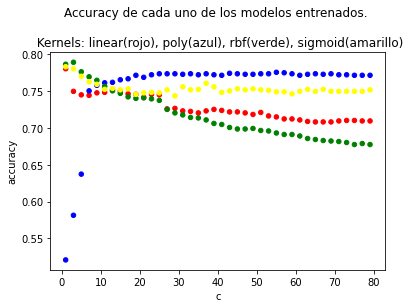

In [317]:
df_segundo_par.plot('c', 'accuracy', kind='scatter',  
    c=[cmap.get(c, 'black') for c in df_segundo_par.k])
plt.title("Accuracy de cada uno de los modelos entrenados. \n \n Kernels: linear(rojo), poly(azul), rbf(verde), sigmoid(amarillo)")
plt.show()

En términos generales, se puede decir que el kernel *poly* resultó en mejores accuracy para valores del parámetro C mayores a 10. A menores valores del parámetro, este kernel es el que consigue menores accuracy.

El segundo en performance es el *sigmoid*.

Por otro lado, exceptuando al kernel *poly*, las mayores accuracy se consiguen con *menores* valores del parámetro C.

A diferencia del conjunto de los clasificadores anteriores, en este caso se encuentran valores de accuracy **menores a 55%**. 

In [319]:
pd.DataFrame(df_segundo_par.groupby('k').describe()['accuracy'][['min','max', 'mean', '50%']])

,min,max,mean,50%
k,,,,
linear,0.708248,0.780504,0.727198,0.722222
poly,0.520791,0.775733,0.756629,0.772324
rbf,0.677573,0.789366,0.716053,0.705521
sigmoid,0.743695,0.783231,0.753528,0.751875


La máxima accuracy alcanzada es similar para todos los kernels probados (**77.6-78.9%**).

**Matriz de confusión**

Mejores parámetros para cada kernel.

In [320]:
df_linear=pd.DataFrame(df_segundo_par.loc[df_segundo_par['k']=='linear'].sort_values(['accuracy'], ascending=False).iloc[0])
df_linear

,0
c,1
accuracy,0.780504
k,linear


In [321]:
df_poly=pd.DataFrame(df_segundo_par.loc[df_segundo_par['k']=='poly'].sort_values(['accuracy'], ascending=False).iloc[0])
df_poly

,109
c,55
accuracy,0.775733
k,poly


In [322]:
df_rbf=pd.DataFrame(df_segundo_par.loc[df_segundo_par['k']=='rbf'].sort_values(['accuracy'], ascending=False).iloc[0])
df_rbf

,6
c,3
accuracy,0.789366
k,rbf


In [323]:
df_sigmoid=pd.DataFrame(df_segundo_par.loc[df_segundo_par['k']=='sigmoid'].sort_values(['accuracy'], ascending=False).iloc[0])
df_sigmoid

,3
c,1
accuracy,0.783231
k,sigmoid


Se muestran las matrices de confusión correspondientes al modelo con mayor accuracy de cada kernel.

*Linear*

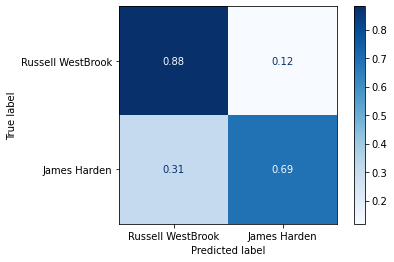

In [324]:
clf_segundo_par = svm.SVC(kernel='linear', C=1)
clf_segundo_par.fit(df_tf_segundo_par_train, vector_tweets_segundo_par_train)
clf_segundo_par.predict(df_segundo_par_test)

plot_confusion_matrix(clf_segundo_par, df_segundo_par_test, vector_tweets_segundo_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Russell WestBrook', 'James Harden'])
plt.show()

*Poly*

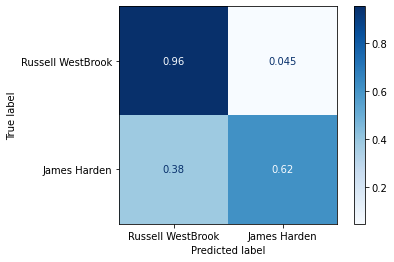

In [325]:
clf_segundo_par = svm.SVC(kernel='poly', C=55)
clf_segundo_par.fit(df_tf_segundo_par_train, vector_tweets_segundo_par_train)
clf_segundo_par.predict(df_segundo_par_test)

plot_confusion_matrix(clf_segundo_par, df_segundo_par_test, vector_tweets_segundo_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Russell WestBrook', 'James Harden'])
plt.show()

*Rbf*

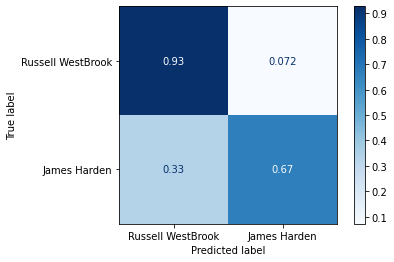

In [326]:
clf_segundo_par = svm.SVC(kernel='rbf', C=3)
clf_segundo_par.fit(df_tf_segundo_par_train, vector_tweets_segundo_par_train)
clf_segundo_par.predict(df_segundo_par_test)

plot_confusion_matrix(clf_segundo_par, df_segundo_par_test, vector_tweets_segundo_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Russell WestBrook', 'James Harden'])
plt.show()

*Sigmoid*

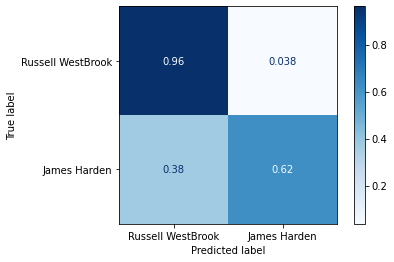

In [327]:
clf_segundo_par = svm.SVC(kernel='sigmoid', C=1)
clf_segundo_par.fit(df_tf_segundo_par_train, vector_tweets_segundo_par_train)
clf_segundo_par.predict(df_segundo_par_test)

plot_confusion_matrix(clf_segundo_par, df_segundo_par_test, vector_tweets_segundo_par_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 display_labels=['Russell WestBrook', 'James Harden'])
plt.show()

**Observaciones**

Como se mencionó anteriormente, la **accuracy** de los mejores modelos se encuentra entre el **77.6** y el **78.9%**, valores **10 puntos porcentuales por debajo** de los encontrados para el primer par de usuarios. 

En las cuatro matrices de confusión presentadas se observan resultados similares. Los tweets de **Russell Westbrook** son correctamente clasificados en alrededor del **88-96%** de los casos, mientras que los tweets de **James Harden** son clasificados correctamente en el **62-69%** de los casos.  

## Conclusiones

- El análisis presentado indica que la hipótesis de que los tweets del *par de personas que están relacionadas* son más difíciles de discriminar que los tweets del *par de personas que no están relacionadas*, es **verdadera**.


- No obstante, los resultados de accuracy para el par de personas no-relacionadas no resultaron tan bajos como esperaba y esto se lo atribuyo tanto a la presencia del hashtah *#whynot* en los tweets de Russell Westbrook como a la cantidad de retweets que tweetea con su nombre de usuario.


- Podría realizarse un análisis similar, descartando tanto a los retweets en forma de tweets con el prefijo RT como a los hashtags. Aunque considero que no sería lo ideal porque esta aproximación dejaría de lado información relevante de la red social que se está analizando.   